In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [41]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [47]:
train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\patry\OneDrive\Pulpit\dataset_bez_val\train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 23782 images belonging to 5 classes.


In [48]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\patry\OneDrive\Pulpit\dataset_bez_val\train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5943 images belonging to 5 classes.


In [49]:
test_dataset = test_datagen.flow_from_directory(directory = r'C:\Users\patry\OneDrive\Pulpit\dataset_bez_val\test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7475 images belonging to 5 classes.


In [50]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [51]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [52]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_9 (Batc  (None, 32)               128       
 hNormalization)                                      

In [54]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [55]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [56]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [57]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [58]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 100,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/100
372/372 [==============================] - 318s 851ms/step - loss: 1.5075 - accuracy: 0.7925 - precision: 0.3584 - recall: 0.0473 - auc: 0.6729 - f1_score: 0.0825 - val_loss: 1.4332 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7125 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
372/372 [==============================] - 275s 740ms/step - loss: 1.3869 - accuracy: 0.8001 - precision: 0.5020 - recall: 0.0481 - auc: 0.7338 - f1_score: 0.0859 - val_loss: 1.3232 - val_accuracy: 0.8055 - val_precision: 0.7971 - val_recall: 0.0370 - val_auc: 0.7634 - val_f1_score: 0.0698 - lr: 0.0010
Epoch 3/100
372/372 [==============================] - 279s 750ms/step - loss: 1.3409 - accuracy: 0.8035 - precision: 0.5460 - recall: 0.1031 - auc: 0.7550 - f1_score: 0.1647 - val_loss: 1.3639 - val_accuracy: 0.8035 - val_precision: 0.6744 - val_recall: 0.0342 - val_auc: 0.7480 - val_f1_score: 0.0642 - lr: 0.0010
Epoch 4/100
372/372 [===================

In [59]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()

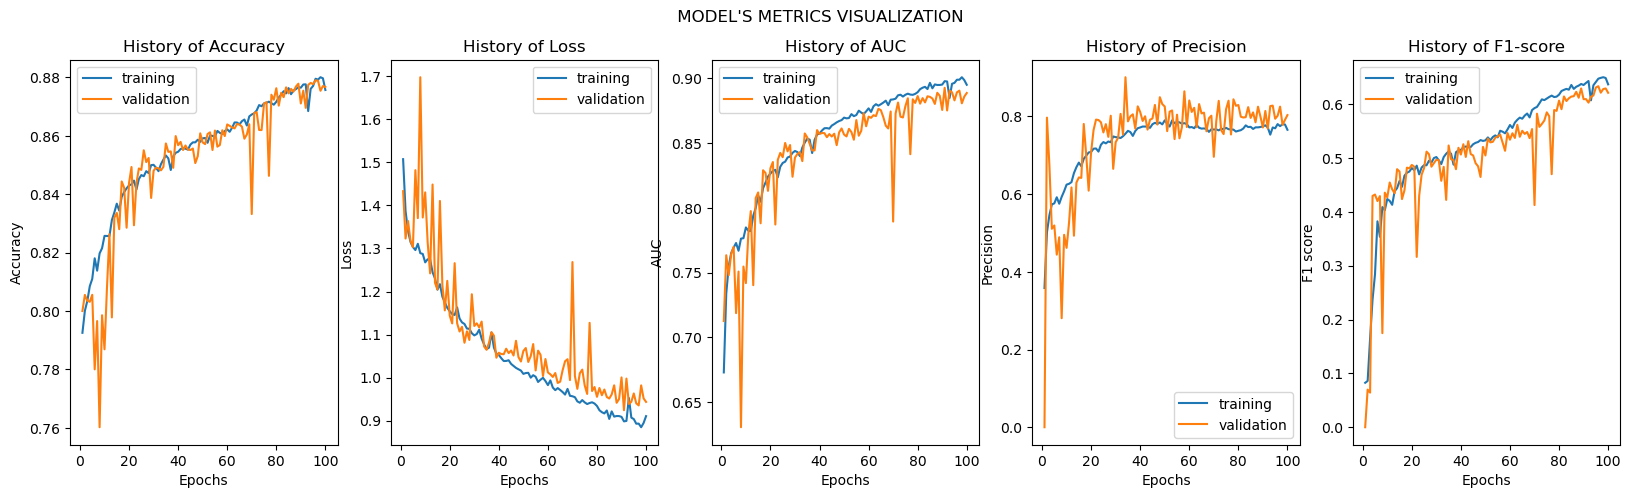

In [60]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )